# 1D Waves in C and Python

In this notebook and associated example, we have three goals:

1.  We want to show how to discretize a 1D wave equation with finite differences
2.  We want to show off how to interface C to Python using Cython
3.  We want to illustrate how to use Python for animations

We begin by importing several Python modules.  The last of these, the `waves` module,
is a code that we wrote ourselves.  This is based on the `_waves.pyx` interface file that
creates a Python-to-C interface to the `time_step` function in `waves.c`.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import waves

Once we have imported the waves package, we can run our 1D wave simulation.  The time stepper takes in two consecutive steps and produces the solution vector at the next time step; we only record every tenth step.  We reserve the two end points for boundary values in each array (the first argument `b` to the time step function tells us how many time steps we need).  We set up initial conditions consistent with a Gaussian pulse moving to the right at the wave speed; if we've done things right, it should move right, reflect off the right boundary, and then traverse the domain and reflect off the left boundary.  We only record once every ten time steps.  We might be tempted to record more, but it's already slow enough to generate the movie without recording ten times as many frames!  We can't make our time step much larger without generating the stability condition (also called the CFL condition).

In [2]:
# Set up an n-point uniform mesh
n = 1000
dx = 1.0/(n-1)
x0 = np.linspace(0.0,1.0,n)

# Speed of sound, space step, time step
c = 1.0
dt = 5e-4

# Sanity check the physical constants
C = c*dt/dx
print("CFL constant is {0} (should be < 1 for stability)".format(C))

# Set up initial conditions
u0 = np.exp(-(5*(x0-0.5))**2)
u1 = np.exp(-(5*(x0-0.5-c*dt))**2)
a = []

# Space for time steps
for i in range(5000):
    u2 = np.zeros(n, dtype=np.double)
    waves.time_step_func(1, u0, u1, u2, c, dx, dt)
    if i % 10 == 0:
        a.append(u2)
    u0 = u1
    u1 = u2

CFL constant is 0.4995 (should be < 1 for stability)


Once we have computed the solution, it's time for a plot.  We use the animate functionality in matplotlib, together with the ability for Jupyter to create Javascript-based animations.

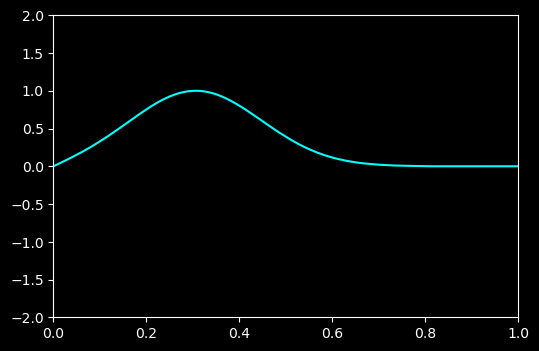

In [3]:
plt.style.use('dark_background')

fig = plt.figure()
fig.set_dpi(100)
ax1 = fig.add_subplot(1,1,1)
k = 0

def animate(i):
    global k
    x = a[k]
    k += 1
    ax1.clear()
    plt.plot(x0,x,color='cyan')
    #plt.grid(True)
    plt.ylim([-2,2])
    plt.xlim([0.0,1.0])
    
anim = animation.FuncAnimation(fig,animate,frames=360,interval=20)
HTML(anim.to_jshtml())

## Exercises

1.  For the numerically inclined: look at `waves.c` and convince yourself that this actually does implement one step of a finite difference scheme where we have used second-order finite difference stencils for both the space and time derivatives.
1.  Re-run the code above with a time step that slightly violates the CFL condition (say `dt = 1.2e-3`).  What happens?
2.  Re-write the code to split the domain in half, each represented in separate arrays, and advance each half independently by 10 steps at a time (as one might do with message passing parallelism).  This does not require changing the C time stepping routine, but it will require keeping extra "ghost cells" for each of the two halves of the domain, and copying data back and forth between them.